In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import glob
import numpy as np

## Import & combine generation and index data

In [2]:
def make_gen_index(data_folder, time='Monthly'):
    """
    Read and combine the state-level generation and index files
    
    inputs:
        data_folder: (str or path) path to the state-level data files
        time: (str) "Monthly", "Quarterly", or "Annual"
        
    outputs:
        gen_index: (df) a dataframe with combined generation and index data
    """
    
    index_path = os.path.join(data_folder, '{} index*'.format(time))
    gen_path = os.path.join(data_folder, '{} gen*'.format(time))
    
    # Get filenames and list of state abbreviations
    index_fns = glob.glob(index_path)
    gen_fns = glob.glob(gen_path)
    
    # Not sure why, but DC shows up in index but not gen
    index_states = [f.split('.')[0][-2:] for f in index_fns]
    gen_states = [f.split('.')[0][-2:] for f in gen_fns]
    
    
    # Read and combine files into single dataframes
    def read_combine(paths, states):
        df_list = []
        for f, state in zip(paths, states):
            df = pd.read_csv(f)
            df['State'] = state
            df_list.append(df)
        
        full_df = pd.concat(df_list)
        full_df.reset_index(inplace=True, drop=True)
        full_df.rename(columns={'year': 'Year'},
                       inplace=True)
        
        if 'datetime' in full_df.columns:
            full_df['datetime'] = pd.to_datetime(full_df['datetime'])
        
        return full_df
    
    index_df = read_combine(index_fns, index_states)
    gen_df = read_combine(gen_fns, gen_states)
    
#     return index_df, gen_df
    
    # Different timescales will pivot on different columns
    gen_pivot_col = {'Monthly': ['Year', 'datetime'],
                     'Quarterly': ['Year', 'year_quarter'],
                     'Annual': ['Year']}
    
    gen_pivot = pd.pivot_table(gen_df, index=['State'] + gen_pivot_col[time], 
                               values='generation (MWh)', columns='fuel category')
    gen_pivot.reset_index(inplace=True, drop=False)
#     gen_pivot['Year'] = gen_pivot['datetime'].dt.year
    gen_pivot.replace(np.nan, 0, inplace=True)
    
    # Merge gen and index dataframes
    merge_col = {'Monthly': ['datetime'],
                 'Quarterly': ['year_quarter'],
                 'Annual': ['Year']}
    
    gen_index = pd.merge(gen_pivot, index_df[merge_col[time] + ['State', 'index (g/kWh)', 'final CO2 (kg)']], 
                         on=merge_col[time] + ['State'])
    
    return gen_index

In [3]:
data_path = os.path.join('Data storage', 'final state data')
monthly_gen_index = make_gen_index(data_path, time='Monthly')
annual_gen_index = make_gen_index(data_path, time='Annual')

## State RPS information

In [11]:
path = os.path.join('Data storage', 'rps_compliance_data_july_2017.xlsx')
rps = pd.read_excel(path, header=35, parse_cols='A:V', na_values=['-'])

In [12]:
rps.index = rps.index.droplevel([1, 2])

In [13]:
rps.head()

,,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
AZ,Total RPS,NaN,NaN,54260.7610,138530.430,217023.802,2.991887e+05,4.078420e+05,4.442978e+05,6.311217e+05,6.622695e+05,8.244299e+05,1.015858e+06,1.183221e+06,1.438960e+06,1.630649e+06,1797523.00,2.00291e+06,2.39481e+06
NaN,DG Carve-Out,NaN,NaN,26980.3805,68620.838,107477.771,1.777578e+05,2.221464e+05,2.468606e+05,2.063521e+05,6.313031e+04,1.180203e+05,1.943070e+05,2.958726e+05,4.151730e+05,4.698070e+05,519195.00,579450,693024
CA,Total RPS,NaN,NaN,NaN,NaN,NaN,2.013914e+07,2.174804e+07,2.360594e+07,2.564308e+07,2.757276e+07,2.955658e+07,3.742798e+07,4.519504e+07,4.618472e+07,4.583003e+07,36206000.00,38142000,no data
CO,Total RPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.980430e+05,1.692921e+06,1.646899e+06,1.680998e+06,4.200079e+06,4.252424e+06,4.272576e+06,4254165.71,7.36085e+06,no data
NaN,DG Carve-Out,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.592200e+04,6.022600e+04,5.806500e+04,6.021300e+04,1.515430e+05,1.530015e+05,1.916715e+05,190610.00,267668,no data


In [22]:
rps.index.names = ['State', 'Type']

In [15]:
idx = pd.IndexSlice

In [23]:
rps.loc[idx[:, :]]

1999      2000          2001  \
State Type                                                           
AZ    Total RPS                        NaN       NaN  5.426076e+04   
NaN      DG Carve-Out                  NaN       NaN  2.698038e+04   
CA    Total RPS                        NaN       NaN           NaN   
CO    Total RPS                        NaN       NaN           NaN   
NaN      DG Carve-Out                  NaN       NaN           NaN   
CT    Total RPS                        NaN       NaN           NaN   
NaN      Class I                       NaN       NaN           NaN   
         Class II                      NaN       NaN           NaN   
DC    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         Tier I Non-Solar              NaN       NaN           NaN   
         Tier II                       NaN       NaN           NaN   
DE    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         New Non-Solar                 NaN       NaN           NaN   
         Existing                      NaN       NaN           NaN   
HI    Total RPS                        NaN       NaN           NaN   
IA    Total RPS                   295800.0  295800.0  2.958000e+05   
IL    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         DG Carve-Out                  NaN       NaN           NaN   
KS    Total RPS                        NaN       NaN           NaN   
MA    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         Class I Non-Solar             NaN       NaN           NaN   
         Class II Existing RE          NaN       NaN           NaN   
         Class II MSW                  NaN       NaN           NaN   
MD    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         Tier I Non-Solar              NaN       NaN           NaN   
...                                    ...       ...           ...   
NJ    Total RPS                        NaN       NaN  2.132289e+06   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         Class I                       NaN       NaN  3.553815e+05   
         Class II                      NaN       NaN  1.776908e+06   
NM    Total RPS                        NaN       NaN           NaN   
NaN      Wind Carve-Out                NaN       NaN           NaN   
         Solar Carve-Out               NaN       NaN           NaN   
         Biomass/Other Carve Out       NaN       NaN           NaN   
         DG Carve-Out                  NaN       NaN           NaN   
NV    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
NY    Total RPS                        NaN       NaN           NaN   
NaN      DG Carve-Out                  NaN       NaN           NaN   
         Main Tier                     NaN       NaN           NaN   
OH    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
OR    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
PA    Total RPS                        NaN       NaN           NaN   
NaN      Solar Carve-Out               NaN       NaN           NaN   
         Tier I Non-Solar              NaN       NaN           NaN   
         Tier II                       NaN       NaN           NaN   
RI    Total RPS                        NaN       NaN           NaN   
NaN      New                           NaN       NaN           NaN   
         Existing                      NaN      

In [28]:
rps.xs('Total RPS', level='Type').reset_index()

,State,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,AZ,NaN,NaN,54260.761,138530.43,2.170238e+05,2.991887e+05,4.078420e+05,4.442978e+05,6.311217e+05,6.622695e+05,8.244299e+05,1.015858e+06,1.183221e+06,1.438960e+06,1.630649e+06,1.797523e+06,2.00291e+06,2.39481e+06
1,CA,NaN,NaN,NaN,NaN,NaN,2.013914e+07,2.174804e+07,2.360594e+07,2.564308e+07,2.757276e+07,2.955658e+07,3.742798e+07,4.519504e+07,4.618472e+07,4.583003e+07,3.620600e+07,38142000,no data
2,CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.980430e+05,1.692921e+06,1.646899e+06,1.680998e+06,4.200079e+06,4.252424e+06,4.272576e+06,4.254166e+06,7.36085e+06,no data
3,CT,NaN,NaN,NaN,NaN,NaN,1.333200e+06,1.426500e+06,1.520094e+06,2.022531e+06,2.424807e+06,2.606049e+06,2.973792e+06,3.204940e+06,3.458575e+06,3.775133e+06,3.988821e+06,4.56259e+06,4.91661e+06
4,DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.819020e+05,5.186850e+05,5.915760e+05,6.998870e+05,7.616580e+05,8.076703e+05,1.040328e+06,1.204696e+06,1380910,1.27895e+07
5,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.187265e+05,2.137110e+05,2.914510e+05,4.106184e+05,5.540980e+05,5.482181e+05,4.329850e+05,4.076480e+05,441902,no data
6,HI,NaN,NaN,NaN,NaN,NaN,NaN,8.787404e+05,NaN,NaN,NaN,NaN,1.001310e+06,9.961654e+05,9.639158e+05,9.500991e+05,9.406166e+05,1.40829e+06,1.39266e+06
7,IA,295800.0,295800.0,295800.000,295800.00,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,2.958000e+05,295800,295800
8,IL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.210441e+06,3.134783e+06,5.252644e+06,6.829078e+06,9.713401e+06,1.165849e+07,1.145803e+07,1.10345e+07,no data
9,KS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.647710e+06,2.621430e+06,2.621430e+06,2.621430e+06,n/a,n/a


In [34]:
rps_tidy = pd.melt(rps.xs('Total RPS', level='Type').reset_index(), 
                   id_vars='State', var_name='Year', value_vars=rps.columns, 
                   value_name='Generation').dropna().sort_values(['State', 'Year'])

In [48]:
list(rps_tidy['State'].head())

['AZ', 'AZ', 'AZ', 'AZ', 'AZ']

In [35]:
for state in rps_tidy['State'].unique():
    first_year = rps_tidy.loc[rps_tidy['State'] == state, 'Year'].min()
    print('{} {}'.format(state, first_year))

AZ 2001
CA 2004
CO 2007
CT 2004
DC 2007
DE 2007
HI 2005
IA 1999
IL 2008
KS 2011
MA 2003
MD 2006
ME 2000
MI 2012
MN 2002
MO 2011
MT 2008
NC 2010
NH 2008
NJ 2001
NM 2006
NV 2003
NY 2006
OH 2009
OR 2011
PA 2006
RI 2007
TX 2002
WA 2012
WI 2000


## Dumbell plot of annual state index

### Dumbell plot code
https://github.com/iturki/Data-Analysis-and-Visualization-Projects/blob/master/dumbbell-chart-python/dumbbbell_plot.py

In [50]:
sns.set()
sns.set_style('white')

In [83]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.mencoder_args': [],
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.15',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
         

In [96]:
def dumbell_plot(a, b, axis_labels, rps_states, fig_kwargs={}):
    '''
    This is an example to create a dumbbell chart in Python.
    If you would like to provide your data and customize the graph, modify the variables in the section below.
    Please be aware that you need matplotlib installed in order for this to work.
    '''
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = sns.color_palette('deep')
    A_COLOR = colors[0] #'#EA2BA2'  # Color to plot a values
    B_COLOR = colors[2] #'#006666'  # Color to plot b values
    LINE_COLOR = '#000000'  # Color to plot the line between dumbbells
    REVERSED_ORDER = False  # Order of plotting (False: bottom to top. True: top to bottom)
    ########## Modify Above ##########

    # Styles to be used when plotting the different elements of the graph.
    dumbbell_style_a = dict(color=A_COLOR, linewidths=2,# mec=A_COLOR,
                            marker='o', s=50)# markersize=9)
    dumbbell_style_b = dict(color=B_COLOR, linewidths=2,# mec=B_COLOR,
                            marker='o', s=50) #markersize=9)
    line_style = dict(color=LINE_COLOR, linestyle='-')
    axis_label_style = dict(horizontalalignment='right', verticalalignment='center', fontsize=10)
#     data_label_style = dict(horizontalalignment='center', verticalalignment='center', color='white', weight='bold',
#                             fontsize=8, fontdict={'family': 'monospace'})

    # By default, data will be plotted bottom to top. If True, this will reverse the order (top to bottom)
    if (REVERSED_ORDER):
        a.sort_index(ascending=False, inplace=True)
        b.sort_index(ascending=False, inplace=True)
        axis_labels.sort_index(ascending=False, inplace=True)

    # Create the figure
    fig, ax = plt.subplots(**fig_kwargs)
#     ax = fig.add_subplot(111)

    # Get min and max values (for plotting purposes)
    _min = min([min(a), min(b)]) - 1
    _max = max([max(a), max(b)]) + 1

    index = range(len(a))
    # Loop N times
    for _a, _b, label, i in zip(a, b, axis_labels, index):
        facecolor = None
        if label in rps_states:
            facecolor = 'w'
        # Plot the line between dumbbells
        dx = _b - _a
#         ax.arrow(x=_a, y=i, dx=dx, dy=0, length_includes_head=True)
    # The arrow seemed slightly high, so I'm shifting it down 0.05    
#     plt.annotate("", xy=(_b + 15, i - 0.05), xytext=(_a, i - 0.05), 
#                      arrowprops=dict(arrowstyle='-|>', ec=None,
#                                      fc='k'))
        plt.hlines(y=i, xmin=_a - 15, xmax=_b + 15, zorder=1, **line_style)
        # Plot the dumbbells.
        ax.scatter(_a, i, facecolors=facecolor, zorder=2, **dumbbell_style_a)
        ax.scatter(_b, i, facecolors=facecolor, zorder=2, **dumbbell_style_b)
        # Add data label on top of dumbbells
#         ax.text(_a, i, _a, **data_label_style)
#         ax.text(_a, i, _b, **data_label_style)
        # Add the axis label
        ax.text(min(_b, _a) - 30, i, label, **axis_label_style)
#     ax.plot(_a, i, label='2001', **dumbbell_style_a)
#     ax.plot(_b, i, label='2016', **dumbbell_style_b)
    plt.yticks(index, ['' for x in axis_labels])
#     plt.legend()

    ax.scatter(300, 50, zorder=2, **dumbbell_style_a)
    ax.scatter(100, 50, zorder=2, **dumbbell_style_b)
    plt.hlines(y=50, xmin=100, zorder=1, xmax=300, **line_style)
    plt.text(x=300, y=51, s='2001', ha='center')
    plt.text(x=100, y=51, s='2016', ha='center')

In [ ]:
barbell_df = annual_gen_index.pivot_table(values='index (g/kWh)', index='State', columns='Year')

(-1, 53)

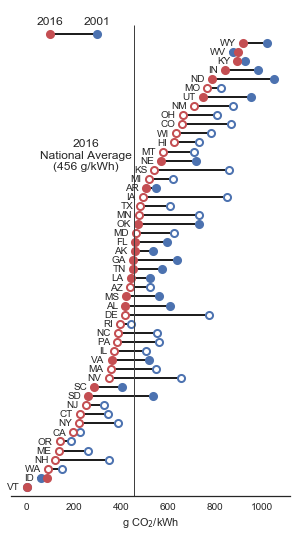

In [97]:
fig_kwargs = dict(figsize=(5,9))
barbell_df = annual_gen_index.pivot_table(values='index (g/kWh)', index='State', columns='Year')
barbell_df.sort_values(by=2016, inplace=True)

index_2005 = barbell_df[2005]
index_2016 = barbell_df[2016]
states = barbell_df.index
rps_states = list(rps_tidy['State'].unique())

dumbell_plot(index_2005, index_2016, states, rps_states, fig_kwargs)

plt.vlines(456, -1, 51, colors=['0.25'], #linestyles='dashed',
           linewidth=1)
plt.ylim(-1, 53)
plt.text(x=250, y=35, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
# plt.legend(loc=4)
plt.xlabel('g CO$_2$/kWh')

(-1, 53)

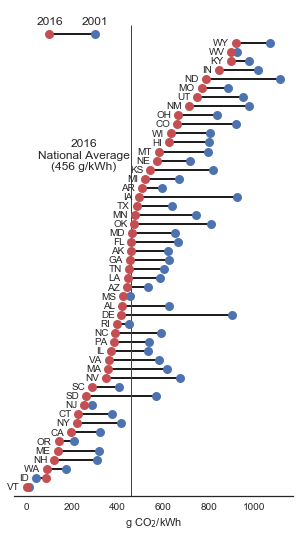

In [34]:
fig_kwargs = dict(figsize=(5,9))
barbell_df = annual_gen_index.pivot_table(values='index (g/kWh)', index='State', columns='Year')
barbell_df.sort_values(by=2016, inplace=True)

index_2001 = barbell_df[2001]
index_2016 = barbell_df[2016]
states = barbell_df.index

dumbell_plot(index_2001, index_2016, states, fig_kwargs)

plt.vlines(456, -1, 51, colors=['0.25'], #linestyles='dashed',
           linewidth=1)
plt.ylim(-1, 53)
plt.text(x=250, y=35, s='2016\nNational Average\n(456 g/kWh)', ha='center')
sns.despine(left=True)
# plt.legend(loc=4)
plt.xlabel('g CO$_2$/kWh')

In [7]:
barbell_df.head()

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
State,,,,,,,,,,,,,,,,,
AK,621.611811,565.861881,548.164631,535.042680,536.961208,560.168723,548.032171,549.446074,540.687033,521.220413,533.580928,521.948966,528.964758,483.442254,480.346550,458.067733,454.483129
AL,623.939526,609.413269,608.499329,588.104495,609.768597,601.561865,605.456713,566.923245,480.671679,522.556200,503.656792,467.973159,461.664737,470.787873,440.129031,419.423304,400.091420
AR,596.142744,561.392736,555.115722,546.477522,548.959686,545.933517,541.966194,532.744797,503.706443,530.823973,566.119614,556.971339,605.307185,581.568651,487.711041,506.662129,522.479681
AZ,530.816009,509.065369,537.409195,522.646083,524.158513,536.935822,534.067799,506.507525,491.879061,495.433946,494.253138,479.015115,502.326656,495.887483,473.726618,438.567707,417.288050
CA,321.348127,265.770910,249.550063,253.040406,224.469855,229.501250,262.682880,264.583352,249.391864,230.568815,198.282483,258.425266,251.917715,250.419616,245.051995,195.519894,151.086244


### Annual emissions

In [4]:
total_emiss = annual_gen_index.groupby('Year')['final CO2 (kg)'].sum()

In [5]:
total_emiss

Year
2001    2.358643e+12
2002    2.381871e+12
2003    2.406899e+12
2004    2.391828e+12
2005    2.436053e+12
2006    2.386896e+12
2007    2.451643e+12
2008    2.397060e+12
2009    2.180317e+12
2010    2.308060e+12
2011    2.213991e+12
2012    2.084190e+12
2013    2.102480e+12
2014    2.098176e+12
2015    1.973093e+12
2016    1.867880e+12
2017    4.118497e+11
Name: final CO2 (kg), dtype: float64

In [12]:
half_states = {}
for year in range(2001, 2017):
    temp = annual_gen_index.loc[annual_gen_index['Year'] == year].copy()
    temp.sort_values(by='final CO2 (kg)', inplace=True)
    
    cumsum_emiss = temp['final CO2 (kg)'].cumsum()
    
    num_half = 50 - (cumsum_emiss <= total_emiss.loc[year]/2).sum()
    half_states[year] = list(temp.loc[~(cumsum_emiss <= total_emiss.loc[year]/2), 'State'].values)
    
    print('In {}, {} states contributed half the total emissions'.format(year, num_half))

In 2001, 11 states contributed half the total emissions
In 2002, 11 states contributed half the total emissions
In 2003, 11 states contributed half the total emissions
In 2004, 11 states contributed half the total emissions
In 2005, 11 states contributed half the total emissions
In 2006, 11 states contributed half the total emissions
In 2007, 11 states contributed half the total emissions
In 2008, 11 states contributed half the total emissions
In 2009, 11 states contributed half the total emissions
In 2010, 11 states contributed half the total emissions
In 2011, 10 states contributed half the total emissions
In 2012, 11 states contributed half the total emissions
In 2013, 11 states contributed half the total emissions
In 2014, 11 states contributed half the total emissions
In 2015, 11 states contributed half the total emissions
In 2016, 11 states contributed half the total emissions


In [15]:
half_states[2011].append(np.nan)

In [17]:
pd.DataFrame(half_states).to_clipboard()

In [31]:
list(set(half_states[2001]).intersection(set(half_states[2016])).intersection(set(half_states)))

['TX', 'OH', 'AL', 'WV', 'PA', 'IL', 'GA', 'IN', 'KY', 'FL']

In [35]:
list(set(x) for x in half_states.values())

[{'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MI', 'MO', 'OH', 'PA', 'TX'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'GA', 'IL', 'IN', 'KY', 'MO', 'OH', 'PA', 'TX'},
 {'AL', 'FL', 'IL', 'IN', 'KY', 'MI', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'IL', 'IN', 'KY', 'MI', 'MO', 'OH', 'PA', 'TX', 'WV'},
 {'AL', 'FL', 'IL', 'IN', 'KY', 'MI', 'M

In [37]:
constant_states = set.intersection(*list(set(x) for x in half_states.values()))

In [42]:
constant_states

{'AL', 'FL', 'IL', 'IN', 'KY', 'OH', 'PA', 'TX'}

In [41]:
for year in range(2001, 2017):
    temp = annual_gen_index.loc[annual_gen_index['Year'] == year].copy()
    percent_emissions = (temp.loc[temp['State'].isin(constant_states), 'final CO2 (kg)'].sum()
                         / total_emiss.loc[year] * 100)
    print 'In {}, they were {:.1f}% of emissions'.format(year, percent_emissions)

In 2001, they were 41.5% of emissions
In 2002, they were 42.0% of emissions
In 2003, they were 42.0% of emissions
In 2004, they were 41.8% of emissions
In 2005, they were 42.0% of emissions
In 2006, they were 42.6% of emissions
In 2007, they were 42.0% of emissions
In 2008, they were 42.2% of emissions
In 2009, they were 42.3% of emissions
In 2010, they were 42.8% of emissions
In 2011, they were 43.8% of emissions
In 2012, they were 43.0% of emissions
In 2013, they were 43.1% of emissions
In 2014, they were 43.0% of emissions
In 2015, they were 41.9% of emissions
In 2016, they were 41.7% of emissions


In [33]:
print half_states[2001]
print half_states[2016]

153    GA
357    MI
816    WV
17     AL
272    KY
221    IL
629    PA
578    OH
238    IN
136    FL
714    TX
Name: State, dtype: object
32     AL
168    GA
406    MO
831    WV
236    IL
287    KY
593    OH
644    PA
253    IN
151    FL
729    TX
Name: State, dtype: object


In [11]:
annual_gen_index.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),final CO2 (kg)
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,621.611811,4.192005e+09
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,565.861881,3.829370e+09
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,548.164631,3.474672e+09
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,535.042680,3.492072e+09
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,536.961208,3.531411e+09


## Gross state product data

In [4]:
us_state_abbrev = {
    'United States': 'US',
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [5]:
path = os.path.join('Data storage', 'GDP data', 'gsp_naics_all_R', 'gsp_naics_all_R.csv')
gsp = pd.read_csv(path)
gsp = gsp.loc[gsp['IndustryId'] == 1]
gsp.drop(['GeoFIPS', 'Region', 'ComponentId', 'ComponentName', 'IndustryId',
          'IndustryClassification', 'Description'], axis=1, inplace=True)
gsp.rename(columns={'GeoName': 'State'}, inplace=True)
gsp = pd.melt(gsp, id_vars='State', var_name='Year', value_name='GSP')
gsp['State'] = gsp['State'].map(us_state_abbrev)

for col in ['Year', 'GSP']:
    gsp.loc[:, col] = pd.to_numeric(gsp.loc[:, col])

In [6]:
gsp.head()

,State,Year,GSP
0,US,1997,11118778
1,AL,1997,137143
2,AK,1997,37880
3,AZ,1997,163114
4,AR,1997,79164


Check to see what percent of GDP is generated in the highest emitting states that are responsible for at least half of US CO<sub>2</sub> emissions from electricity. The fraction is remarkably consistent over time (34-36%). Maybe not too surprising, given that the list of states is pretty stable. 

In [16]:
total_gsp = {}
half_states_gsp = {}
for year in half_states.keys():
    total_gsp[year] = gsp.loc[(gsp['Year'] == year) &
                              (gsp['State'] == 'US'), 'GSP'].sum()
                               
    half_states_gsp[year] = gsp.loc[(gsp['Year'] == year) &
                                    (gsp['State'].isin(half_states[year])), 'GSP'].sum()
                               
    percent = half_states_gsp[year] / total_gsp[year] * 100
                               
    print('In {}, states with half of emissions contributed to {:.1f}% of GDP'.format(year, percent))

In 2001, states with half of emissions contributed to 36.1% of GDP
In 2002, states with half of emissions contributed to 36.1% of GDP
In 2003, states with half of emissions contributed to 35.9% of GDP
In 2004, states with half of emissions contributed to 35.8% of GDP
In 2005, states with half of emissions contributed to 35.6% of GDP
In 2006, states with half of emissions contributed to 34.3% of GDP
In 2007, states with half of emissions contributed to 35.6% of GDP
In 2008, states with half of emissions contributed to 35.2% of GDP
In 2009, states with half of emissions contributed to 36.2% of GDP
In 2010, states with half of emissions contributed to 34.1% of GDP
In 2011, states with half of emissions contributed to 33.8% of GDP
In 2012, states with half of emissions contributed to 34.2% of GDP
In 2013, states with half of emissions contributed to 34.5% of GDP
In 2014, states with half of emissions contributed to 34.5% of GDP
In 2015, states with half of emissions contributed to 34.5% of

In [129]:
annual_gen_index_gsp = annual_gen_index.merge(gsp, on=['State', 'Year'])

In [130]:
non_fuels = ['State', 'Year', 'index (g/kWh)', 'GSP']
gen_cols = [x for x in annual_gen_index.columns if x not in non_fuels]
total_gen = annual_gen_index.loc[:, gen_cols].sum(axis=1)

annual_gen_index_gsp.loc[:, 'CO2 (kg)'] = (total_gen
                                           * annual_gen_index_gsp.loc[:, 'index (g/kWh)'])
annual_gen_index_gsp.loc[:, 'tonne CO2/mmUSD'] = (annual_gen_index_gsp.loc[:, 'CO2 (kg)']
                                                  / annual_gen_index_gsp.loc[:, 'GSP']
                                                  / 1000)

In [131]:
annual_gen_index_gsp.head()

,State,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh),GSP,CO2 (kg),tonne CO2/mmUSD
0,AK,2001,564593.00,1345664.00,3895568.00,0.0,936990.00,0.00,0.0,951.00,621.611811,37102,4.192005e+09,112.985947
1,AK,2002,575286.00,1439351.00,3778161.00,0.0,962369.00,12155.00,0.0,0.00,565.861881,38605,3.829370e+09,99.193616
2,AK,2003,549665.00,1582537.00,3354483.00,0.0,846273.00,5780.00,0.0,0.00,548.164631,38262,3.474672e+09,90.812607
3,AK,2004,648979.71,1498020.01,3623432.59,0.0,747068.06,9216.55,0.0,0.00,535.042680,39648,3.492072e+09,88.076879
4,AK,2005,624317.77,1463942.01,3723625.63,0.0,758928.54,5255.58,0.0,589.01,536.961208,40767,3.531411e+09,86.624243


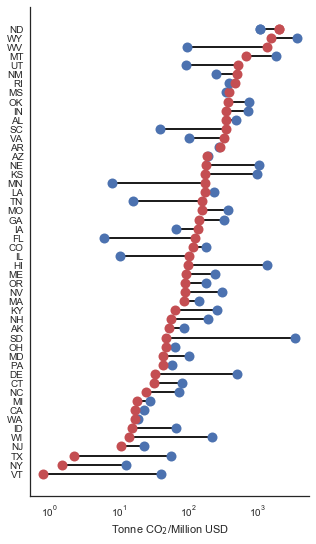

In [140]:
fig_kwargs = dict(figsize=(5,9))
barbell_gsp = annual_gen_index_gsp.pivot_table(values='tonne CO2/mmUSD', index='State', columns='Year')
barbell_gsp.sort_values(by=2016, inplace=True)

index_2005 = barbell_gsp[2005]
index_2016 = barbell_gsp[2016]
states = barbell_gsp.index

dumbell_plot(index_2005, index_2016, states, fig_kwargs)
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
sns.despine()
plt.xlabel('Tonne CO$_2$/Million USD')

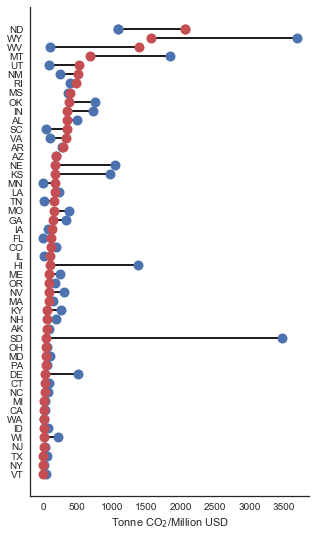

In [141]:
fig_kwargs = dict(figsize=(5,9))
barbell_gsp = annual_gen_index_gsp.pivot_table(values='tonne CO2/mmUSD', index='State', columns='Year')
barbell_gsp.sort_values(by=2016, inplace=True)

index_2005 = barbell_gsp[2005]
index_2016 = barbell_gsp[2016]
states = barbell_gsp.index

dumbell_plot(index_2005, index_2016, states, fig_kwargs)
ax = plt.gca()
# ax.set_xscale("log", nonposx='clip')
sns.despine()
plt.xlabel('Tonne CO$_2$/Million USD')

Calculate variability as the rolling standard deviation of monthly values. Also calculate a normalized value, which divides the rolling standard deviation by the rolling average.

In [8]:
for state in gen_index['State'].unique():
    gen_index.loc[gen_index['State'] == state, 'Index variability'] = \
        gen_index.loc[gen_index['State']==state, 
                       'monthly index (g/kWh)'].rolling(window=12).std()
    
    gen_index.loc[gen_index['State'] == state, 
                   'Normalized Index variability'] = \
         gen_index.loc[gen_index['State']==state, 'Index variability'] / \
         gen_index.loc[gen_index['State']==state, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()
gen_index.tail()

,State,datetime,Coal,Natural Gas,Nuclear,Other,Renewables,Year,monthly index (g/kWh),Index variability,Normalized Index variability
9745,WY,2016-11-01,3136243.00,61286.95,0.0,40986.67,414531.36,2016,916.315369,17.668906,0.019208
9746,WY,2016-12-01,3952815.25,64950.50,0.0,38877.40,583667.43,2016,891.854330,19.201913,0.020905
9747,WY,2017-01-01,3875156.57,72746.85,0.0,45655.70,358419.99,2017,956.145267,22.000973,0.023889
9748,WY,2017-02-01,3140221.06,55896.80,0.0,42111.49,409344.56,2017,925.869631,21.677007,0.023501
9749,WY,2017-03-01,2970256.83,60934.81,0.0,41061.12,502269.26,2017,912.486445,21.853026,0.023716


Add in the percent of generation from each fuel type, and the change in generation from that fuel type since the average in 2001. Maybe change from 2001 to a different year?

In [9]:
base_year = 2005

In [10]:
fuels = ['Coal', 'Natural Gas', 'Renewables', 'Nuclear', 'Other']
gen_index['Total gen'] = gen_index.loc[:, fuels].sum(axis=1)
for fuel in fuels:
    # New columns that are being added
    col_percent = 'percent ' + fuel
    col_change = 'change in ' + fuel

    # Calculate percent of generation from each fuel type
    gen_index[col_percent] = gen_index.loc[:, fuel] / gen_index.loc[:, 'Total gen']

    # Percent of fuel in state in base year (entire year)
    for state in gen_index['State'].unique():
        percent_fuel_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                          (gen_index['State'] == state), fuel].sum() / gen_index.loc[(gen_index['Year'] == 2001) & 
                                                                                                     (gen_index['State'] == state), 'Total gen'].sum()

        # Use percent of fuel in 2001 to calculate change for each state/month
        gen_index.loc[gen_index['State'] == state, 
                      col_change] = (gen_index.loc[gen_index['State'] == state, col_percent] - percent_fuel_base) / percent_fuel_base
    
# Change in variability compared to average base year value
for state in gen_index['State'].unique():
    norm_variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['State'] == state), 'Normalized Index variability'].mean()
    variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['State'] == state), 'Index variability'].mean()
    
    gen_index.loc[gen_index['State'] == state, 
                  'change in variability'] = (gen_index.loc[gen_index['State'] == state, 
                                                            'Index variability'] - variability_base) / variability_base
    
    gen_index.loc[gen_index['State'] == state, 
                  'change in norm variability'] = (gen_index.loc[gen_index['State'] == state, 
                                                            'Normalized Index variability'] - norm_variability_base) / norm_variability_base

Plot the change in variability since 2005 against the change in each fuel type

In [11]:
gen_index.columns

Index([u'State', u'datetime', u'Coal', u'Natural Gas', u'Nuclear', u'Other',
       u'Renewables', u'Year', u'monthly index (g/kWh)', u'Index variability',
       u'Normalized Index variability', u'Total gen', u'percent Coal',
       u'change in Coal', u'percent Natural Gas', u'change in Natural Gas',
       u'percent Renewables', u'change in Renewables', u'percent Nuclear',
       u'change in Nuclear', u'percent Other', u'change in Other',
       u'change in variability', u'change in norm variability'],
      dtype='object')

In [12]:
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.plotting import *
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.palettes import viridis

In [13]:
output_notebook()

Loading BokehJS ...

In [14]:
gen_index.head()

,State,datetime,Coal,Natural Gas,Nuclear,Other,Renewables,Year,monthly index (g/kWh),Index variability,...,percent Natural Gas,change in Natural Gas,percent Renewables,change in Renewables,percent Nuclear,change in Nuclear,percent Other,change in Other,change in variability,change in norm variability
0,AK,2001-01-01,46903.0,367521.0,0.0,71085.0,104636.0,2001,600.293443,NaN,...,0.622764,0.127872,0.177306,-0.186476,0.0,NaN,0.120453,0.070338,NaN,NaN
1,AK,2001-02-01,54056.0,334016.0,0.0,67910.0,90185.0,2001,661.971217,NaN,...,0.611564,0.107588,0.165123,-0.242370,0.0,NaN,0.124339,0.104867,NaN,NaN
2,AK,2001-03-01,51920.0,343858.0,0.0,91413.0,99924.0,2001,664.696930,NaN,...,0.585674,0.060700,0.170195,-0.219101,0.0,NaN,0.155699,0.383523,NaN,NaN
3,AK,2001-04-01,37590.0,290050.0,0.0,76372.0,84686.0,2001,620.075841,NaN,...,0.593516,0.074902,0.173289,-0.204905,0.0,NaN,0.156276,0.388658,NaN,NaN
4,AK,2001-05-01,40986.0,283468.0,0.0,75034.0,85199.0,2001,619.840221,NaN,...,0.584848,0.059203,0.175781,-0.193468,0.0,NaN,0.154809,0.375620,NaN,NaN


In [15]:
def weighted_percent(df, fuel, year):
    all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Renewables']
    temp = df.loc[df['Year'] == year, all_fuels]
    temp['Total'] = temp.sum(axis=1)
    
    weighted_per = temp[fuel].sum() / temp['Total'].sum() * 100
    return weighted_per

In [31]:
def state_bokeh_plot(df, fuel, x_axis, y_axis, x_range, y_range,
                     x_lower_lim=0, x_upper_lim=None):
    figs = {}
    if not x_upper_lim:
        x_upper_lim = df[x_axis].max()
        
    for state in df['State'].unique():
        temp = gen_index.loc[gen_index['State'] == state]
        max_change = temp['change in Renewables'].max()
        
        if max_change <= x_upper_lim and max_change >= x_lower_lim:
            
            source = ColumnDataSource(data=dict(
            x=temp[x_axis],
            y=temp[y_axis],
            datetime=temp['datetime'],
            colors= viridis(len(temp))
            ))
            
            hover = HoverTool(tooltips=[
                                    ("(x,y)", "($x, $y)"),
                                    ("datetime", "@datetime{%F}")],
                             formatters={
                                     'datetime': 'datetime', # use 'datetime' formatter
                                        }
                             )
            hover.point_policy = "snap_to_data"

            fuel_2005 = weighted_percent(temp, fuel, 2005)
            fuel_2016 = weighted_percent(temp, fuel, 2016)
            title = state + ' {:.1f}% to {:.1f}%'.format(fuel_2005, fuel_2016)

            figs[state] = figure(title=title, tools=[hover], y_range=y_range, x_range=x_range,
                                 output_backend="webgl")
            figs[state].circle('x', 'y', source=source, color='colors', size=12, alpha=0.5)
            figs[state].xaxis.axis_label = x_axis
            figs[state].yaxis.axis_label = y_axis

    plots = figs.values()
    grid = gridplot(plots, ncols=4, plot_width=240, plot_height=240)

    show(grid, notebook_handle=True)

## Plots of change in variability against change in renewables
Change in both is measured with reference to the average 2005 values

### States where renewables have increased by 300% or less

In [32]:
state_bokeh_plot(gen_index, 'Renewables', 'change in Renewables', 'change in norm variability',
                 x_range=(-1, 3), y_range=(-2, 7), x_upper_lim=3)

### States where renewables have increased by 300% to 1000%

In [33]:
state_bokeh_plot(gen_index, 'Renewables', 'change in Renewables', 'change in norm variability',
                 x_range=(-2, 10), y_range=(-2, 7), x_lower_lim = 3, x_upper_lim=10)

### States where renewables have increased by 1000+%

In [34]:
state_bokeh_plot(gen_index, 'Renewables', 'change in Renewables', 'change in norm variability',
                 x_range=(-2, 40), y_range=(-2, 7), x_lower_lim=10, x_upper_lim=None)

## Older, non-interactive plots

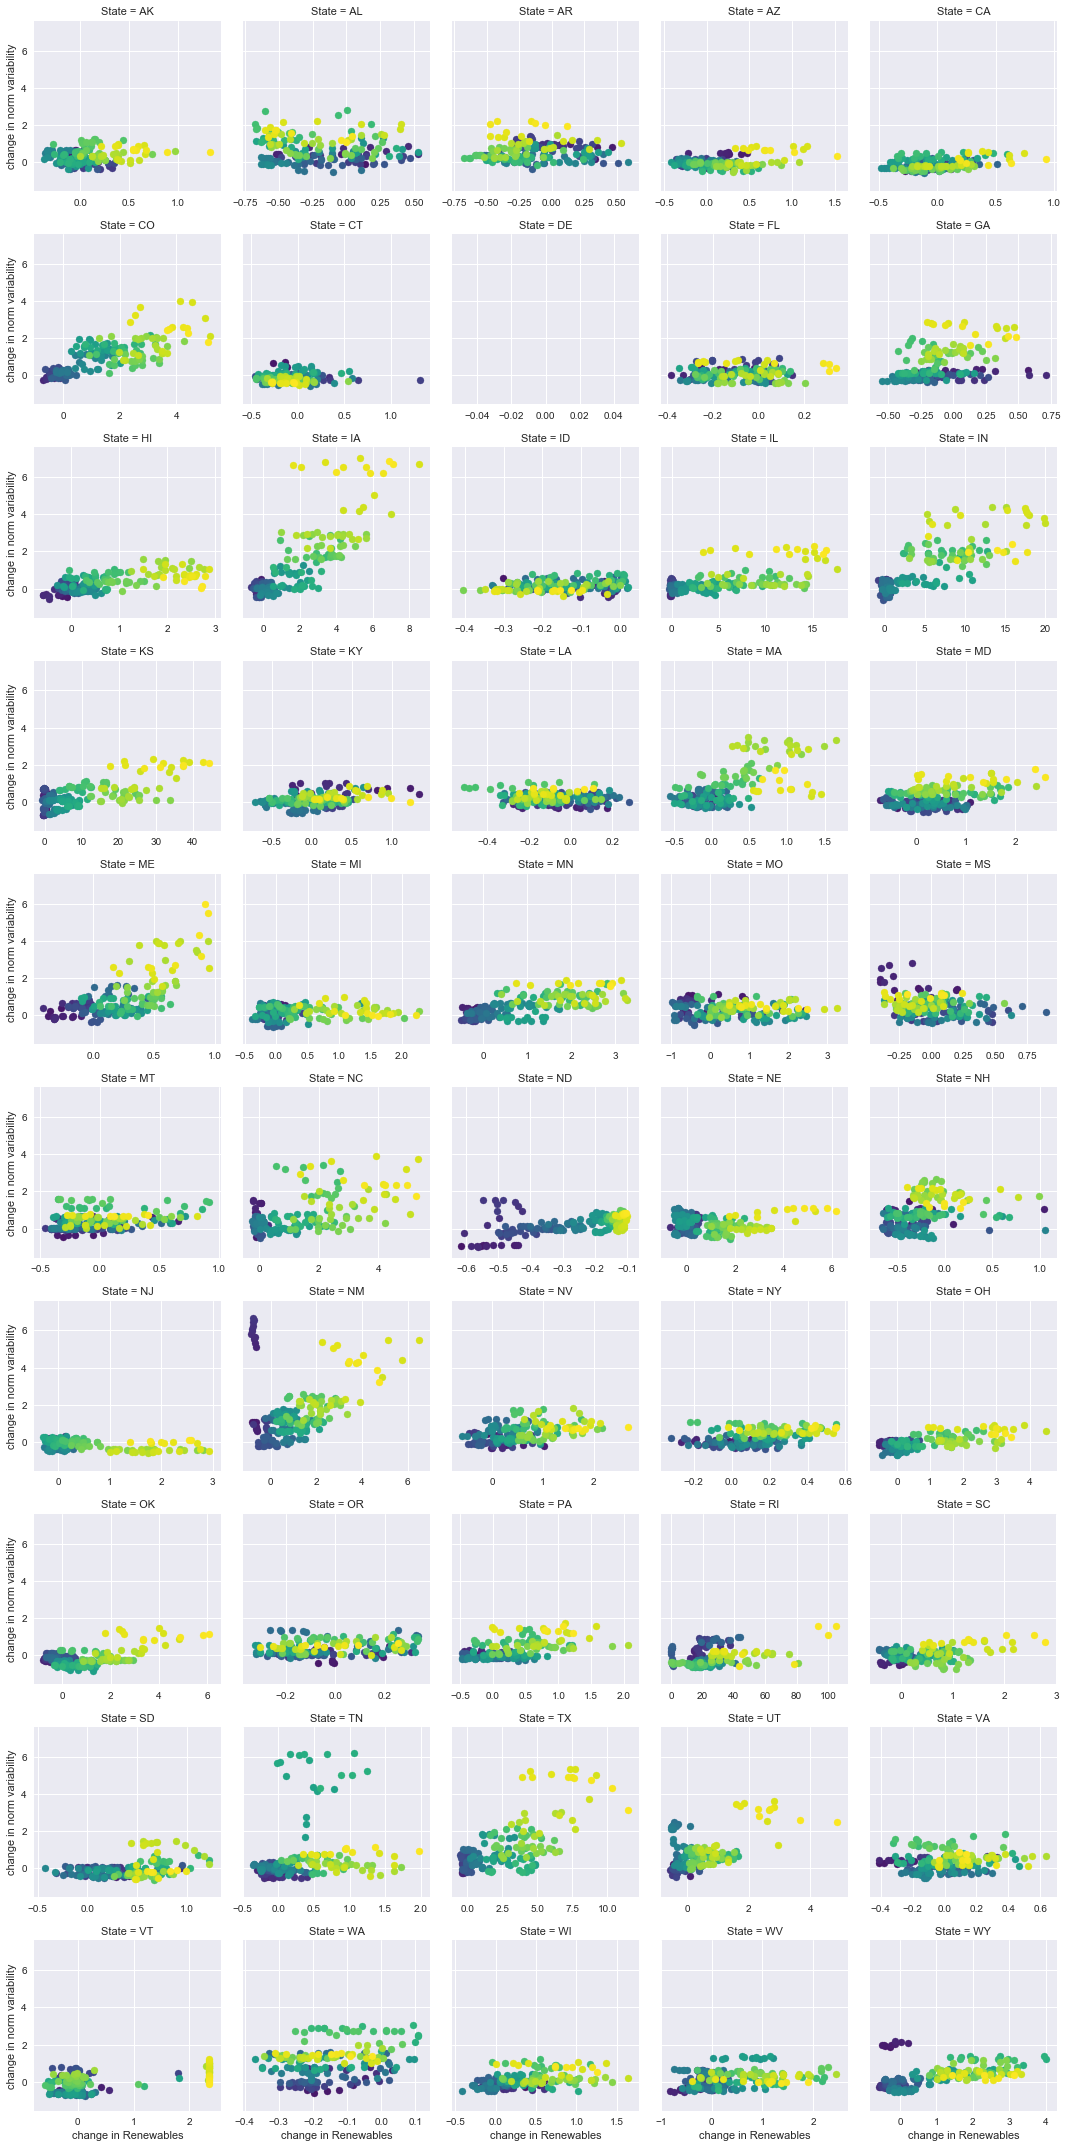

In [29]:
g = sns.FacetGrid(gen_index, col='State', col_wrap=5, sharex=False, 
                  hue='datetime', palette='viridis')
g.map(plt.scatter, 'change in Renewables', 'change in norm variability')

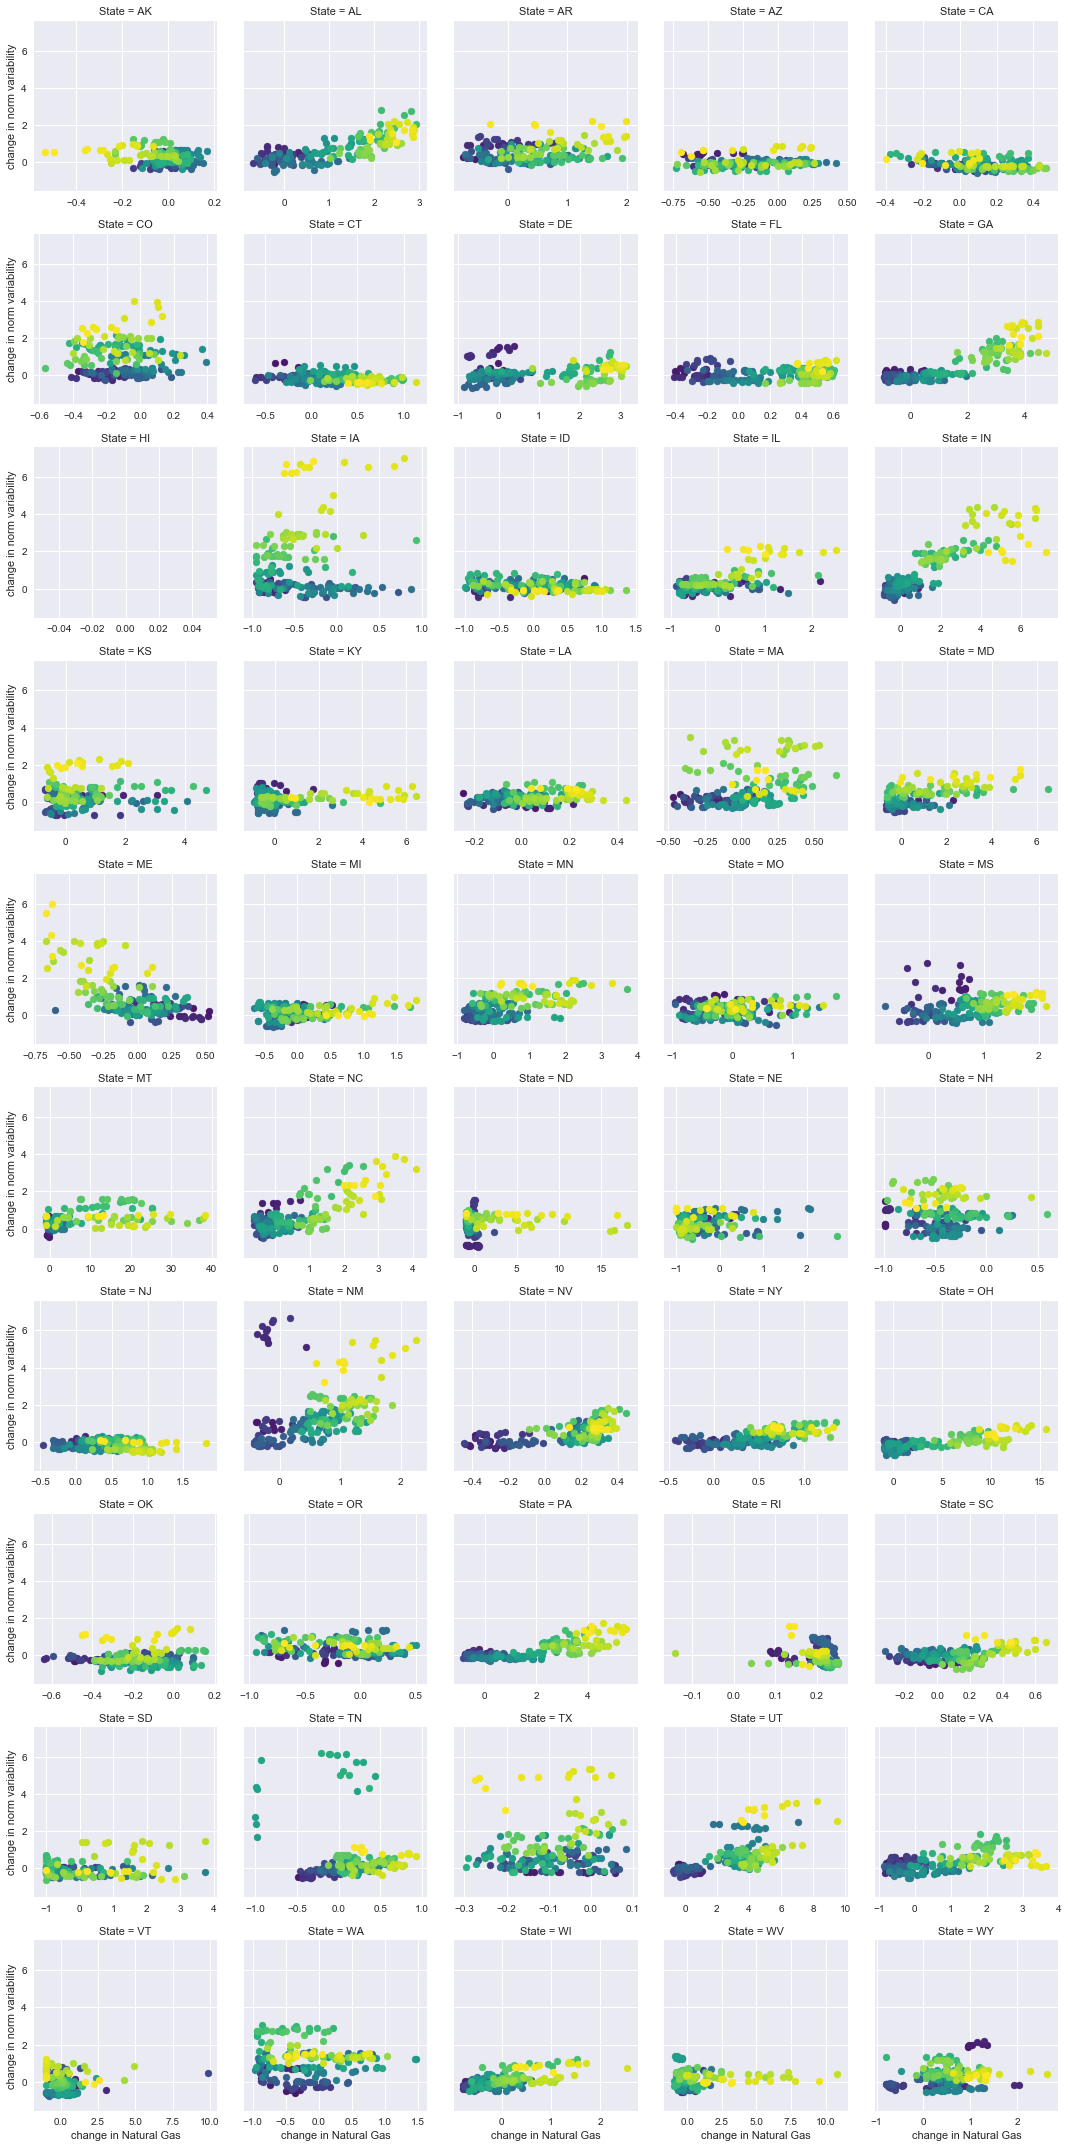

In [30]:
g = sns.FacetGrid(gen_index, col='State', col_wrap=5, sharex=False, 
                  hue='datetime', palette='viridis')
g.map(plt.scatter, 'change in Natural Gas', 'change in norm variability')